# Krzywa C Levy'ego — Projekt I Fraktale

W poniższym notatniku znajduje się implementacja oraz opis projektu I na zajęcia z fraktali. W skład notatnika wchodzi:

1. **Implementacja klasycznego fraktala** — kod oraz demonstacja generacji klasycznej krzywej C Levy'ego.
2. **Modifikacja fraktala** — wprowadzenie kilku modyfikacji fraktali oraz sprawdzenie ich właściwości względem oryginału.
3. **Teoria** — krótki wstęp teoretyczny do samej krzywej C Levy'ego, jej zastosowania, opis.
4. **Analiza i wnioski** — porównanie klasycznej krzywej C Levy'ego oraz jej wariantów, zbadanie metryk dla fraktali, wnioski.

> **Jak uruchomić notatnik:** zainstaluj pakiet `uv` na Twoją platformę, po czym zainstaluj wymagane pakiety komendami `uv sync` oraz `uv sync --extra notebooks`. W następstie możesz uruchomić cały notebook.

Krzywa Levy'ego            |  Paul Pierre Levy
:-------------------------:|:-------------------------:
![](images/Levy_C_Curve_final.png)  |  ![](images/Paul_Pierre_Levy_1886-1971.jpg)

## 3) Teoria: konstrukcja klasyczna i wpływ modyfikacji

- **Opis IFS:** Dwie samopodobne kopie skalowane przez sqrt(2)/2, obrócone o +/- 45 stopnii. Wymiar podobieństwa D = 2.
- **L-system:** Start od aksjomatu `F` i kąta = 45 stopnii; reguła `F -> +F--F+`; interpretacja "żółwia": `F` – rysuj krok, `+` – obrót w prawo o 45 stopnii, `-` – obrót w lewo o 45 stopnii. Każda iteracja tworzy dwie kopie odcinka skalowane o `sqrt(2)/2` i obrócone o +/- 45°, co daje wymiar podobieństwa `D = 2`.

### Krótka historia
Krzywa Lévy’ego C wywodzi się z prac Paula Lévy’ego (lata 30. XX w.) nad geometrią fraktalną i procesami losowymi. Jest szczególnym przypadkiem rodziny fraktali Cesaro dla kąta 45°, a jej opis bywa przedstawiany zarówno przez L-systemy (`F -> +F--F+`), jak i jako IFS z dwiema podobnościami (rotacje +/- 45 stopnii, skala sqrt(2)/2). Stała się popularnym przykładem w dydaktyce fraktali dzięki prostej konstrukcji i "widocznemu" samopodobieństwu.

### Przykłady zastosowań
- Grafika komputerowa i shadery: proceduralne tekstury, maski, poszarpane obrysy (kontrola chropowatości kątem/iteracjami).
- Kompresja fraktalna (IFS): prosty przypadek do testów i demonstracji rekonstrukcji z transformacji samopodobnych.
- Modelowanie brzegów/obrysów: syntetyczne „wybrzeża”, pęknięcia, kontury chmur/liści o wymiarze bliskim 2.
- Inżynieria RF (anteny fraktalne): inspiracja do miniaturyzacji i wielopasmowości dzięki długiej ścieżce na małej powierzchni.
- Planowanie ścieżek/skanowanie: długie, ciągłe trajektorie w ograniczonym oknie (ploter, laser).
- Analiza sygnałów i tekstur: wzorzec do kalibracji miar fraktalnych (wymiar pudełkowy, korelacyjny, lakunarność).


In [ ]:
# Wstepne importy i setup
%matplotlib inline
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from fractals.levy_c import LevyCCurve
from fractals.plotting import plot_scatter, plot_iterations_grid

from fractals.metrics import estimate_box_dimension, lacunarity_gliding_box
from fractals.variants import levy_ifs_generalized

import pandas as pd


# Formatowanie
plt.rcParams.update({
    "figure.figsize": (6, 6),
    "axes.titlesize": 12,
})

## 1) Krzywa Lévy’ego C — teoria

- Konstrukcja (L-system): zaczynamy od aksjomatu "F", kąt = 45 stopni. 
  Zastosuj regułę "F -> +F--F+" przez wybraną liczbę iteracji. Interpretacja "żółwia":
  - "F": narysuj krok do przodu,
  - "+": obróć w prawo o kąt 45 stopni,
  - "-": obróć w lewo o kąt 45 stopni.
- Postać IFS: dwa podobieństwa ze skalą s = sqrt(2)/2 i obrotami o +/- 45 stopnii,
  z translacjami ustawiającymi dwie części tak, aby utworzyły krzywą.
- Wymiar podobieństwa: dla dwóch części o tej samej skali rozwiąż 2 * s^D = 1. 
  Dla s = sqrt(2)/2: 2 * 2^(-D/2) = 1 => D = 2. (Zweryfikujemy też numerycznie metodą "box-counting".)


### Fraktal klasyczny (L-system): formacja od iteracji

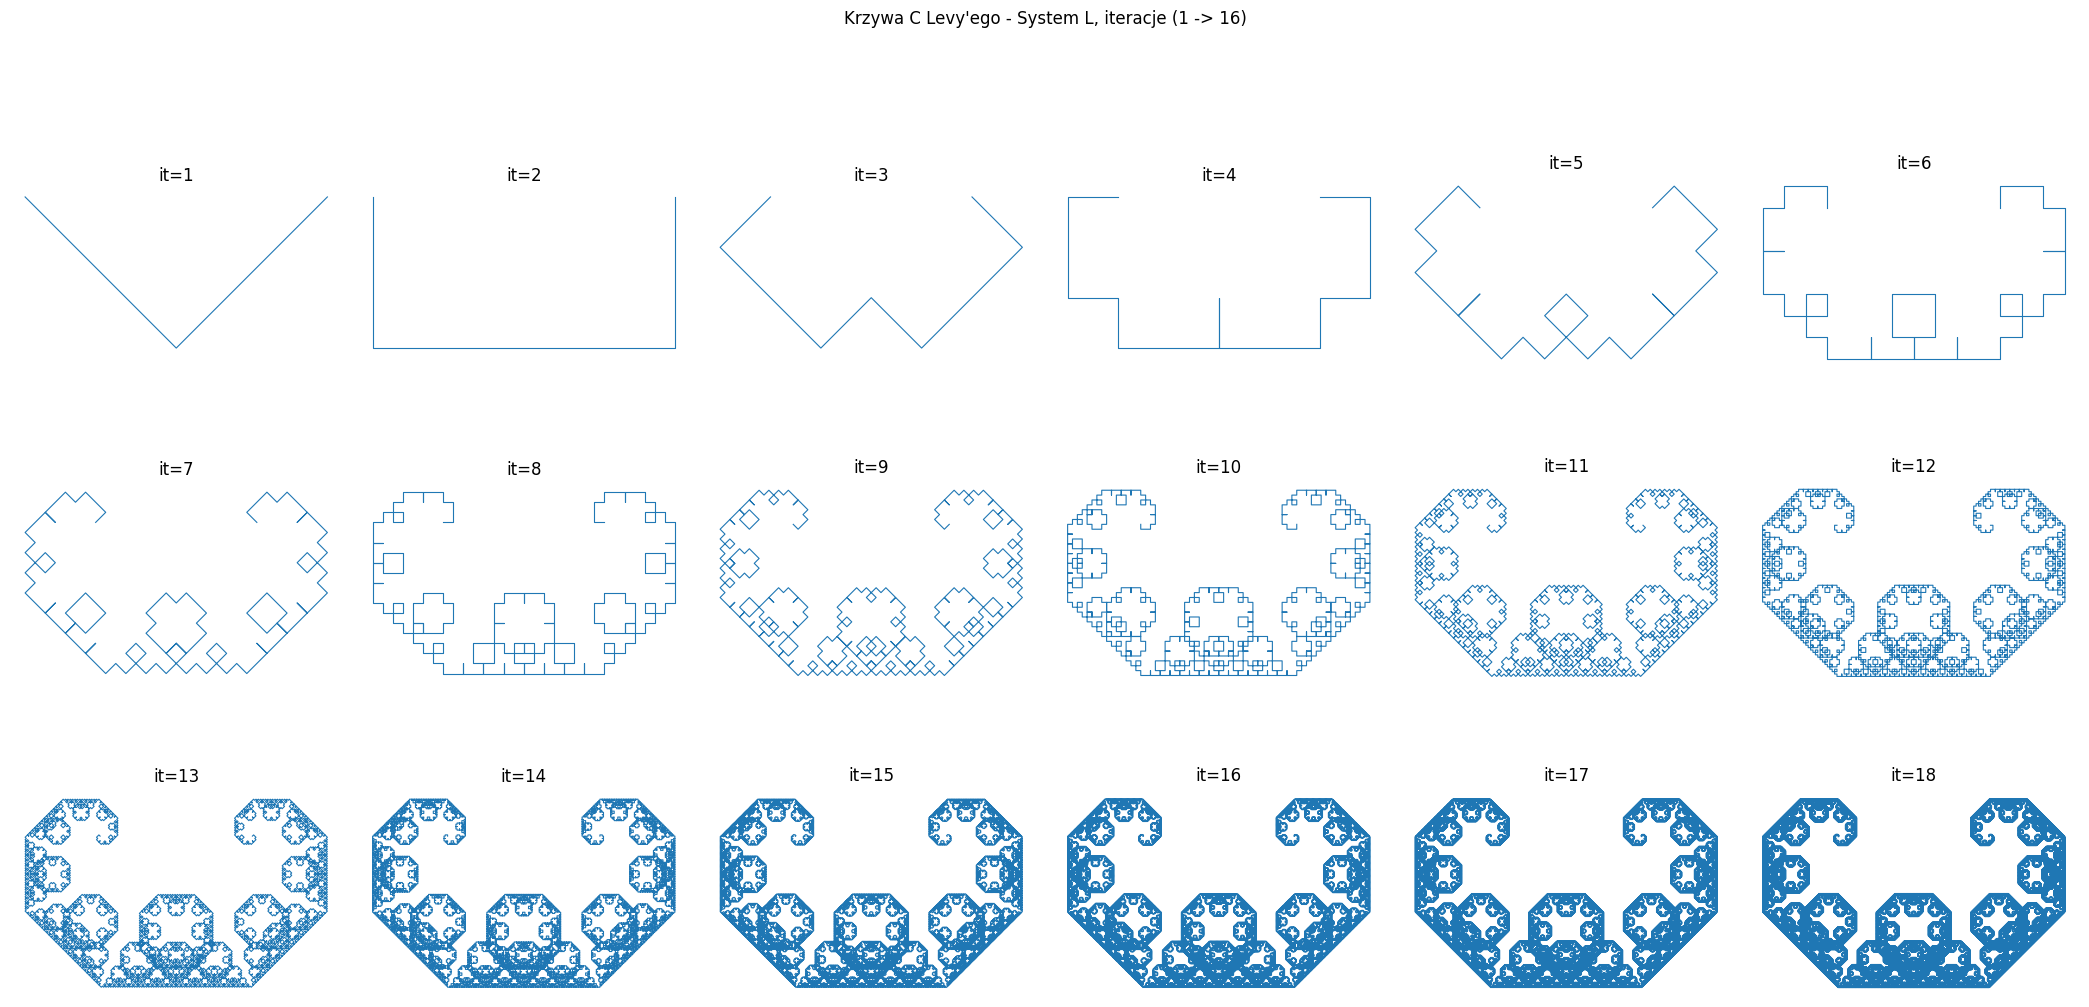

In [ ]:
# Wizualizacja progresji generacji krzywej Levy'ego dla systemu L, w zależności od iteracji
fig = plot_iterations_grid(iter_start=1, iter_stop=18, angle_deg=45.0)
fig.suptitle("Krzywa C Levy'ego - system L, iteracje (1 -> 16)", y=1.03)
plt.show()

### Fraktal klasyczny (IFS): przykład dla zmiennej ilości punktów

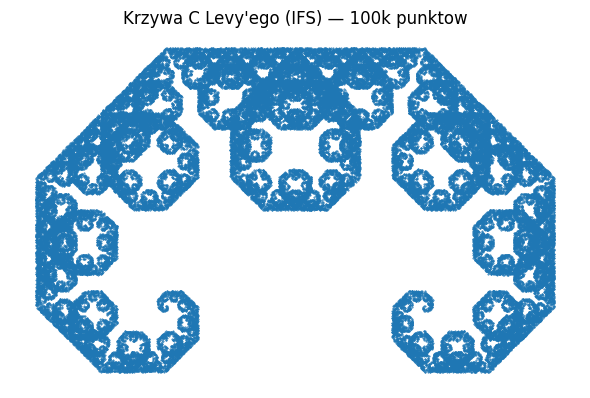

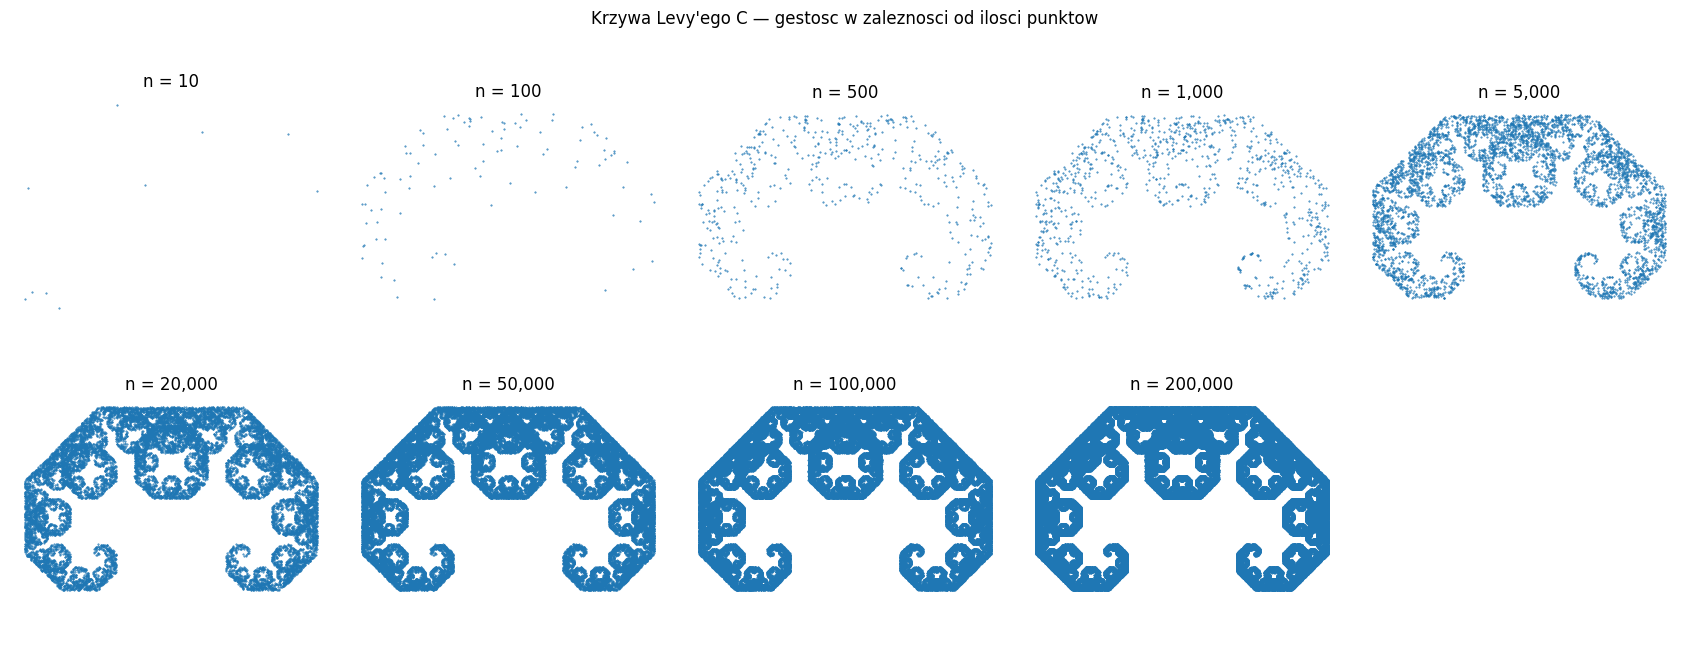

In [10]:
lc_ifs = LevyCCurve(method="ifs", n_points=100_000)
pts_ifs = lc_ifs.generate()
fig = plot_scatter(pts_ifs, s=0.2, title="Krzywa C Levy'ego (IFS) — 100k punktow")
plt.show()

point_counts = [10, 100, 500, 1_000, 5_000, 20_000, 50_000, 100_000, 200_000]
max_per_row = 5
s = 0.2
cell_size = 3.4

total = len(point_counts)
cols = min(total, max_per_row)
rows = (total + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cell_size * cols, cell_size * rows))
axes_list = [axes] if (rows == 1 and cols == 1) else axes.ravel().tolist()

for i, n in enumerate(point_counts):
    lc = LevyCCurve(method="ifs", n_points=int(n))
    pts = lc.generate()
    xs, ys = zip(*pts)
    ax = axes_list[i]
    ax.scatter(xs, ys, s=s)
    ax.set_title(f"n = {n:,}")
    ax.set_aspect("equal")
    ax.axis("off")

for j in range(total, len(axes_list)):
    axes_list[j].axis("off")

fig.suptitle("Krzywa Levy'ego C — gestosc w zaleznosci od ilosci punktow")
fig.tight_layout()
plt.show()


#### Eksperyment do przykładu pierwszego, całkowita długość krzywej

Interpreter L-systemu używa `step = 2^{-iterations/2}` iteracji do rysowania danego fraktala.
Liczba odcinków podwaja się w każdej iteracji, więc długość łamanej rośnie w przybliżeniu eksponencjalnie o podstawie 2. Możemy zmierzyć ten wzrost, aby zobaczyć i zweryfikować trend.

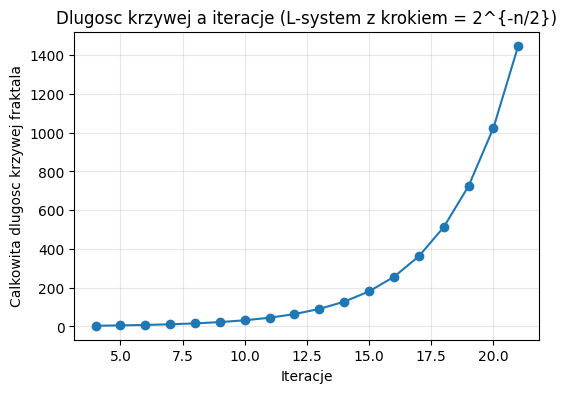

In [12]:
def polyline_length(points):
    pts = np.asarray(points, dtype=float)
    diffs = np.diff(pts, axis=0)
    return float(np.sqrt((diffs**2).sum(axis=1)).sum())

iters = list(range(4, 22))
lengths = []
for it in iters:
    lc = LevyCCurve(method="lsystem", iterations=it, angle_deg=45.0)
    pts = lc.generate()
    lengths.append(polyline_length(pts))

plt.figure(figsize=(6,4))
plt.plot(iters, lengths, "o-")
plt.xlabel("Iteracje")
plt.ylabel("Calkowita dlugosc krzywej fraktala")
plt.title("Dlugosc krzywej a iteracje (L-system z krokiem = 2^{-n/2})")
plt.grid(True, alpha=0.3)
plt.show()

## 2) Modyfikacje klasycznej krzywej

Pokażemy dwa rodzaje modyfikacji przy zachowaniu (lub "prawie"-zachowaniu) **samopodobieństwa** i **iteracyjnej konstrukcji**:

1. **Uogólniony kąt** w IFS (kąt != 45°).  
2. **Stochastyczny L-system**: niewielka perturbacja reguły losowana podczas tworzenia krzywej.

Obie wersje zachowują "cechy fraktali": pierwsza to deformacja geometryczna, druga wprowadza kontrolowaną losowość.


### 2.1 Uogólniony kąt dla IFS (alpha-Levy) — wizualizacja dla wybranych kątów

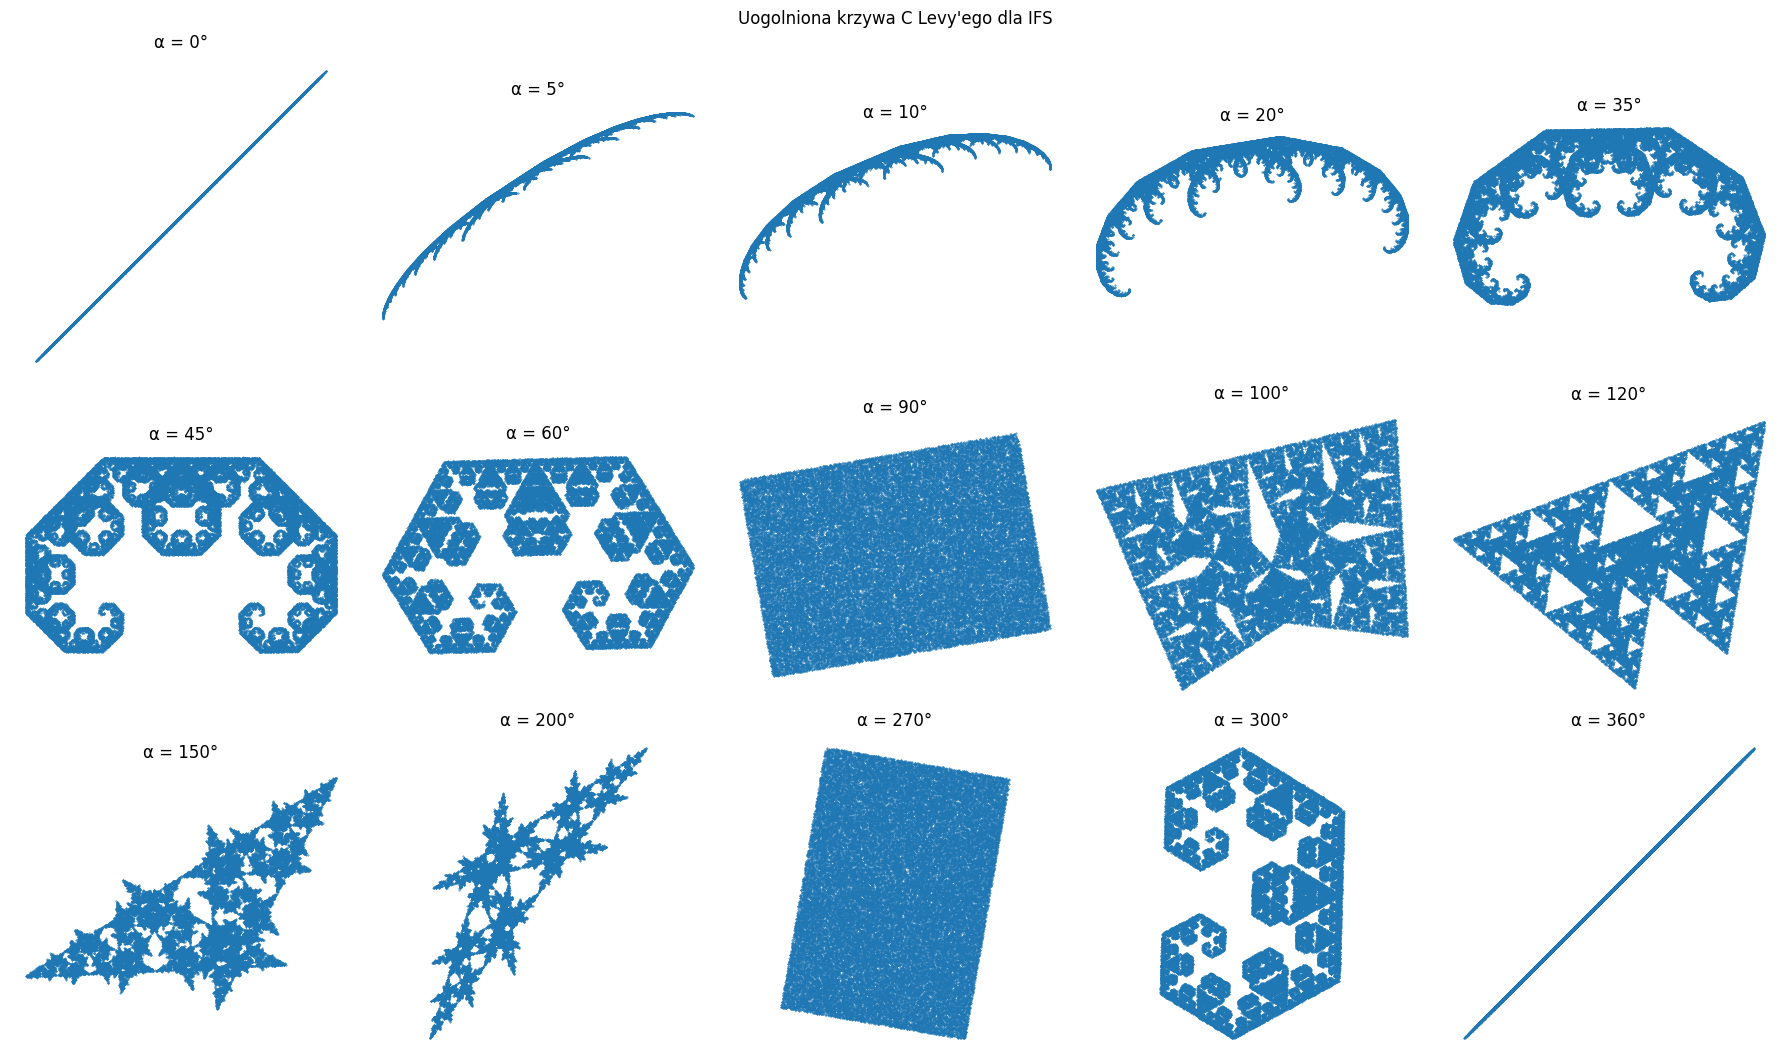

In [ ]:
angles = [0, 5, 10, 20, 35, 45, 60, 90, 100, 120, 150, 200, 270, 300, 360]
max_per_row = 5
n_points = 60_000
discard = 100
s = 0.15
cell_size = 3.6

total = len(angles)
cols = min(total, max_per_row)
rows = (total + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cell_size * cols, cell_size * rows))
axes_list = [axes] if (rows == 1 and cols == 1) else axes.ravel().tolist()

for idx, ang in enumerate(angles):
    ifs = levy_ifs_generalized(angle_deg=ang)
    pts = ifs.sample(n_points=n_points, discard=discard, seed=int(ang))
    xs, ys = zip(*pts)
    ax = axes_list[idx]
    ax.scatter(xs, ys, s=s)
    ax.set_title(f"Kat = {ang}°")
    ax.set_aspect("equal")
    ax.axis("off")

for j in range(total, len(axes_list)):
    axes_list[j].axis("off")

fig.suptitle("Uogolniona krzywa C Levy'ego dla IFS")
fig.tight_layout()
plt.show()


### 2.2 Stochastyczny L-system - wariant

Dokonamy modyfikacji, która będzie dokonywała probabilistycznej zmiany zasad klasycznej reguły `+F--F+` w naszym L systemie,
dzięki, której będziemy wprowadzać losowe zmiany względem klasycznego fraktala, "mniej więcej" zachowując jego cechy.

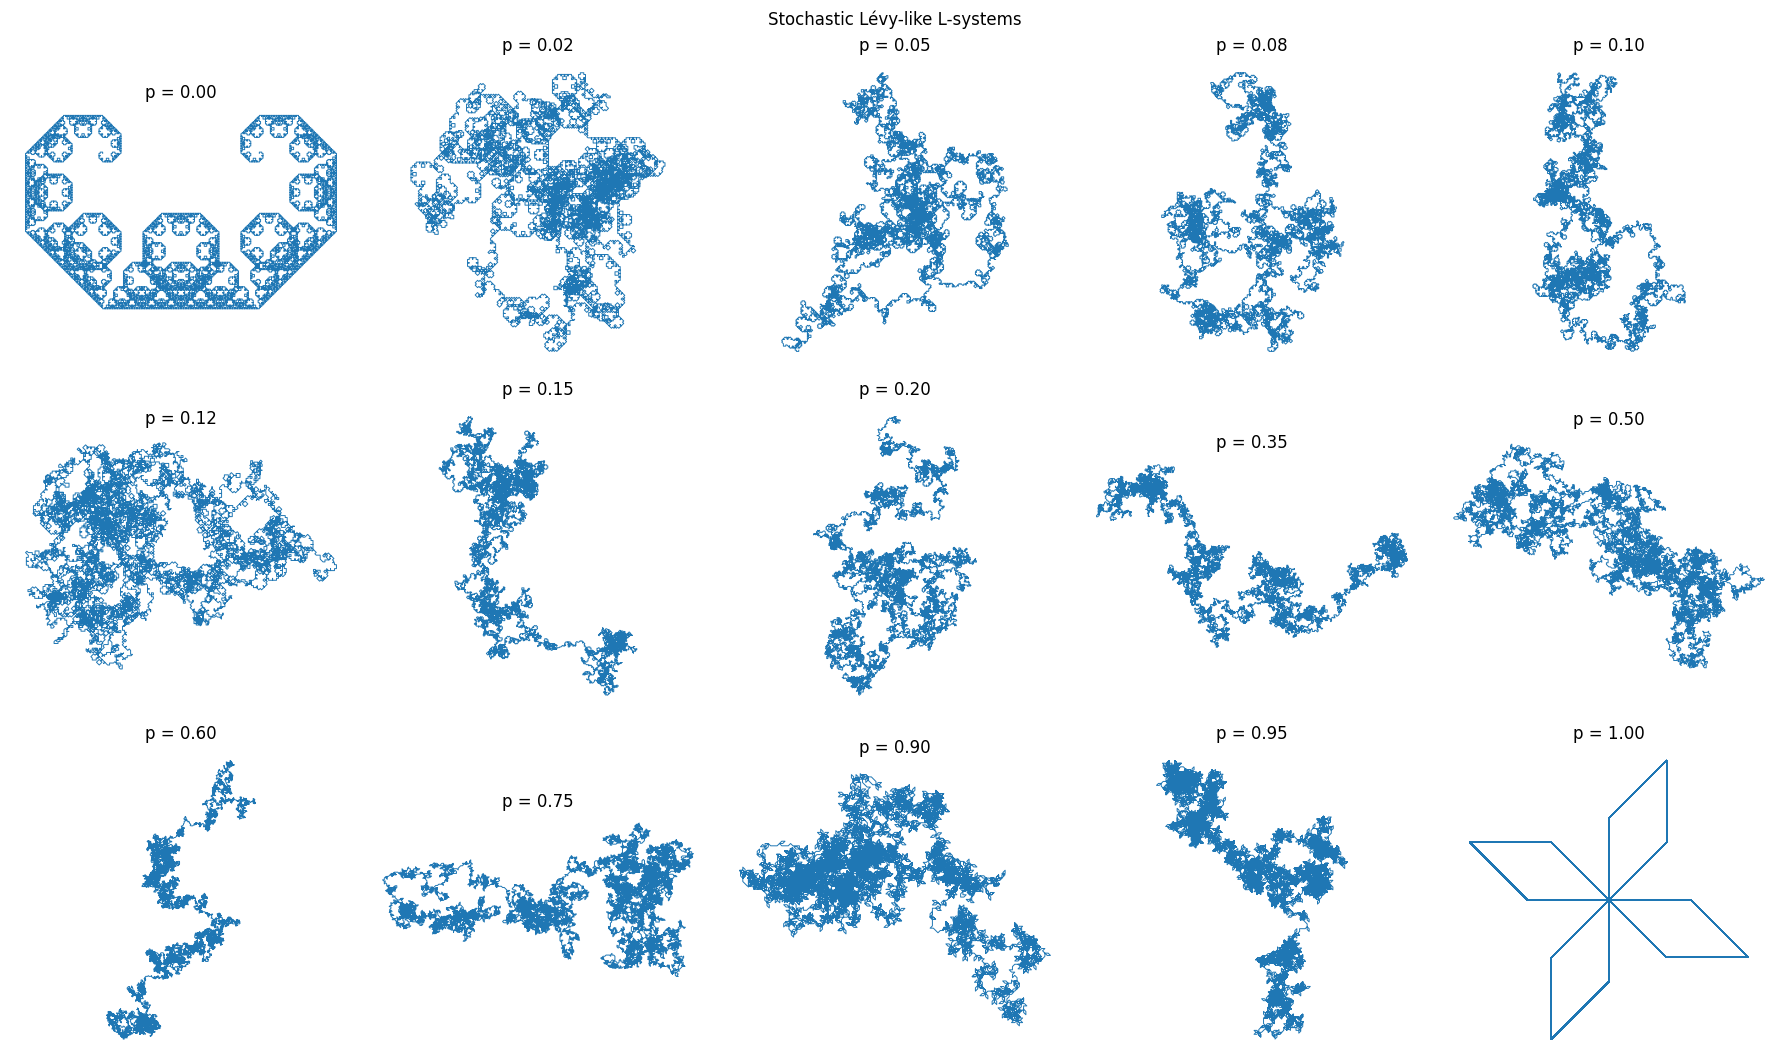

In [8]:
def lsystem_expand_stochastic(axiom, iterations, p=0.25):
    rule_classic = "+F--F+"
    rule_variant = "+F+-+F+"
    s = axiom
    for _ in range(iterations):
        out = []
        for ch in s:
            if ch == "F":
                out.append(rule_variant if random.random() < p else rule_classic)
            else:
                out.append(ch)
        s = "".join(out)
    return s

def lsystem_interpret_turtle(instructions, angle_deg, step):
    x, y, heading = 0.0, 0.0, 0.0
    ang = math.radians(angle_deg)
    pts = [(x, y)]
    for ch in instructions:
        if ch == "F":
            x += step*math.cos(heading)
            y += step*math.sin(heading)
            pts.append((x, y))
        elif ch == "+":
            heading -= ang
        elif ch == "-":
            heading += ang
    return pts

probs = [0.0, 0.02, 0.05, 0.08, 0.10, 0.12, 0.15, 0.20, 0.35, 0.5, 0.6, 0.75, 0.90, 0.95, 1.00]
iters = 14
max_per_row = 5
cell_size = 3.6
linewidth = 0.7

total = len(probs)
cols = min(total, max_per_row)
rows = (total + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cell_size * cols, cell_size * rows))
axes_list = [axes] if (rows == 1 and cols == 1) else axes.ravel().tolist()

for idx, p in enumerate(probs):
    instr = lsystem_expand_stochastic("F", iterations=iters, p=p)
    step = 2 ** (-iters / 2)
    pts = lsystem_interpret_turtle(instr, angle_deg=45.0, step=step)
    xs, ys = zip(*pts)
    ax = axes_list[idx]
    ax.plot(xs, ys, linewidth=linewidth)
    ax.set_title(f"p = {p:.2f}")
    ax.set_aspect("equal")
    ax.axis("off")

for j in range(total, len(axes_list)):
    axes_list[j].axis("off")

fig.suptitle("Stochastic Lévy-like L-systems")
fig.tight_layout()
plt.show()


## 4) Analiza i konkluzje

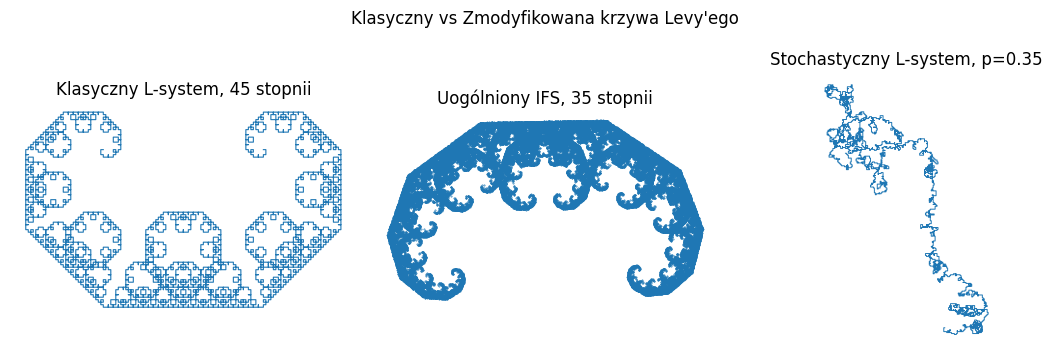

In [13]:
# Porownanie 
fig, axes = plt.subplots(1, 3, figsize=(11, 3.6))

# L system
classic = LevyCCurve(method="lsystem", iterations=12, angle_deg=45.0).generate()
xs, ys = zip(*classic); axes[0].plot(xs, ys, linewidth=0.8)
axes[0].set_title("Klasyczny L-system, 45 stopnii"); axes[0].set_aspect("equal"); axes[0].axis("off")

# Uogólniony kąt dla IFS, 35 stopnii
ifs = levy_ifs_generalized(angle_deg=35.0)
pts = ifs.sample(n_points=80_000, discard=100, seed=42)
xs, ys = zip(*pts); axes[1].scatter(xs, ys, s=0.15)
axes[1].set_title("Uogólniony IFS, 35 stopnii"); axes[1].set_aspect("equal"); axes[1].axis("off")

# Stochastyczny L-sysytem, p=0.35
instr = lsystem_expand_stochastic("F", iterations=12, p=0.35)
pts = lsystem_interpret_turtle(instr, angle_deg=45.0, step=2**(-12/2))
xs, ys = zip(*pts); axes[2].plot(xs, ys, linewidth=0.7)
axes[2].set_title("Stochastyczny L-system, p=0.35"); axes[2].set_aspect("equal"); axes[2].axis("off")

fig.suptitle("Klasyczny vs Zmodyfikowana krzywa Levy'ego")
fig.tight_layout()
plt.show()

### Empiryczny wymiar Minkowskiego

Teraz oszacujemy wymiar Minkowskiego procedurą regresji dla "zliczania komórek" dla każdej wersji.
Dla samopodobnych konstrukcji w stylu Levy’ego oczekujemy wartości bliskich 2.


In [16]:
def make_points_classic(it=13, angle=45.0):
    return LevyCCurve(method="lsystem", iterations=it, angle_deg=angle).generate()

def make_points_angle_variant_ifs(angle=35.0, n_points=80_000, seed=123):
    return levy_ifs_generalized(angle_deg=angle).sample(n_points=n_points, discard=200, seed=seed)

def make_points_stochastic(it=12, p=0.35, angle=45.0):
    instr = lsystem_expand_stochastic("F", iterations=it, p=p)
    step = 2 ** (-it / 2)
    return lsystem_interpret_turtle(instr, angle_deg=angle, step=step)

models = {
    "Klasyczny (iteracje=13, kat=45 stopnii)": lambda: make_points_classic(13, 45.0),
    "IFS kat=35 stopnii (80k)":        lambda: make_points_angle_variant_ifs(35.0, 80_000, 123),
    "IFS=60 stopnii (80k)":        lambda: make_points_angle_variant_ifs(60.0, 80_000, 321),
    "Stochastyczne p=0.15":           lambda: make_points_stochastic(12, 0.15, 45.0),
    "Stochastyczne p=0.35":           lambda: make_points_stochastic(12, 0.35, 45.0),
}


,D_box,Lambda(delta_min)
name,,
"Klasyczny (iteracje=13, kat=45 stopnii)",1.2227,5.2734
IFS kat=35 stopnii (80k),1.6783,2.8845
IFS=60 stopnii (80k),1.6694,2.8088
Stochastyczne p=0.15,0.9247,6.0864
Stochastyczne p=0.35,0.8651,5.9656


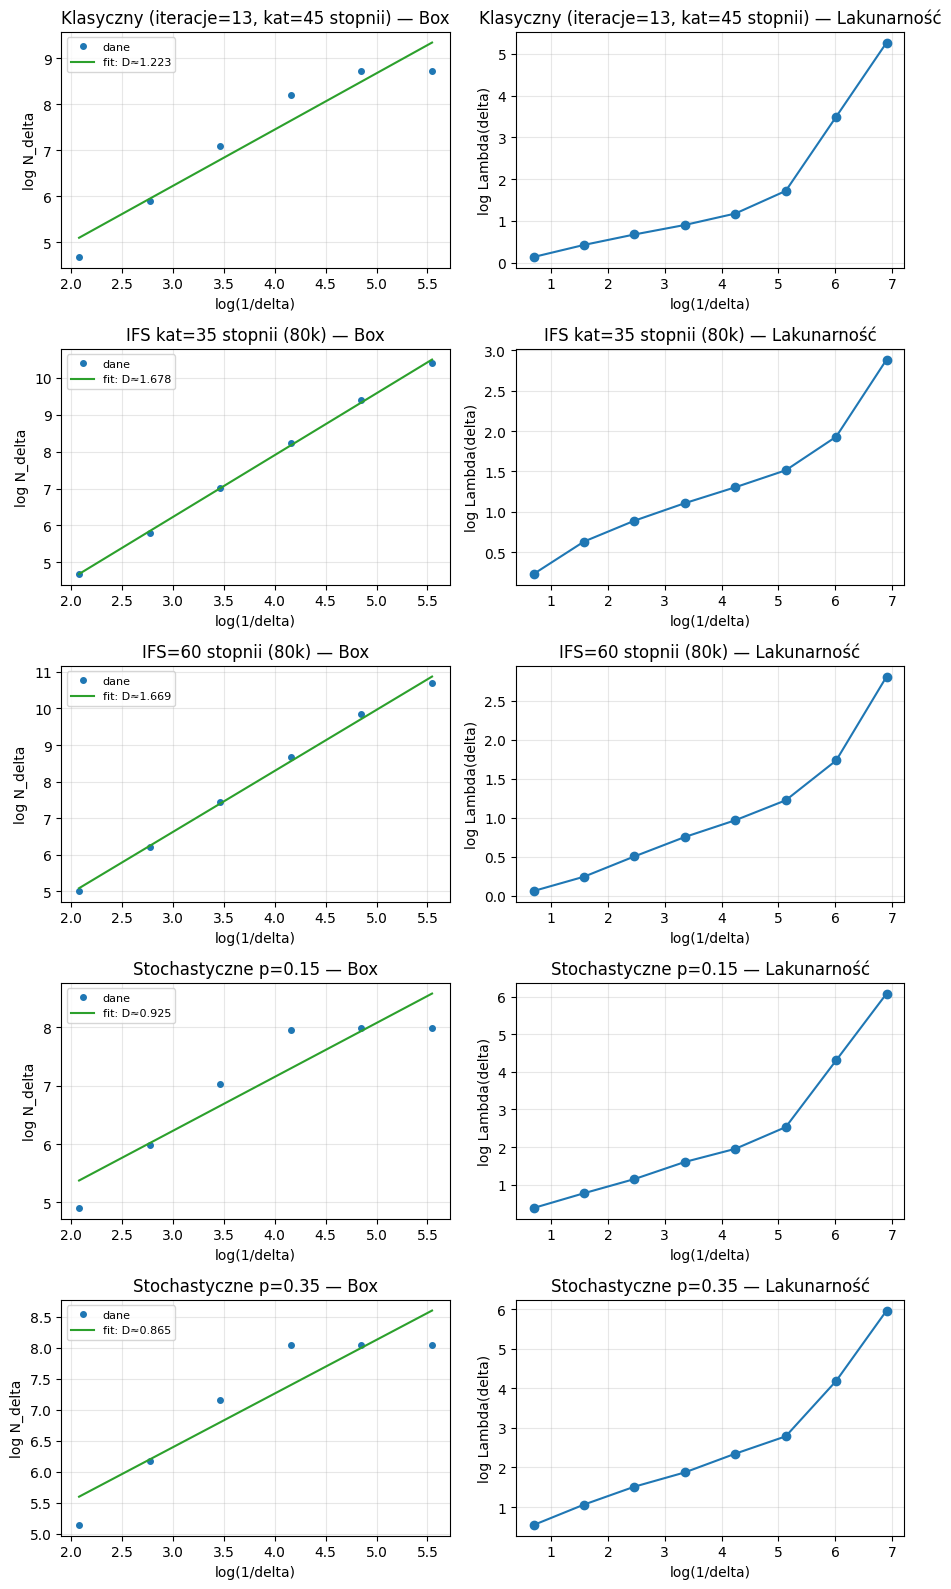

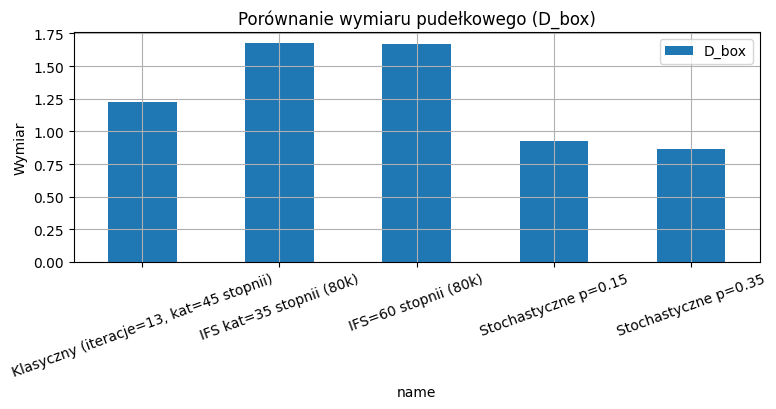

In [ ]:
# Skale
box_deltas = [2**(-k) for k in range(3, 9)]
lac_deltas = np.logspace(-3.0, -0.3, 8)

rows = []
per_model = []

for name, maker in models.items():
    pts = maker()

    # Wymiar pudełkowy 
    fig_b, res_b = estimate_box_dimension(pts, deltas=box_deltas, title_prefix=name)
    plt.close(fig_b)
    x_box = np.log(1.0 / res_b.deltas)
    y_box = np.log(res_b.counts)
    y_box_fit = res_b.slope * x_box + res_b.intercept

    # Lakunarność 
    fig_l, res_l = lacunarity_gliding_box(pts, deltas=lac_deltas, title=name)
    plt.close(fig_l)
    x_lac = np.log(1.0 / res_l.deltas)
    y_lac = np.log(res_l.lacunarity)

    rows.append({
        "name": name,
        "D_box": res_b.slope,
        "Lambda(delta_min)": float(np.log(res_l.lacunarity[0])),
    })
    per_model.append({
        "name": name,
        "x_box": x_box, "y_box": y_box, "y_box_fit": y_box_fit,
        "x_lac": x_lac, "y_lac": y_lac,
    })

df = pd.DataFrame(rows).set_index("name")
display(df.round(4))

# Siatka wykresów: 1) Wymiar Minkowskiego, 2) Lakunarność
n_models = len(per_model)
cols = 2
rows_grid = n_models
fig, axes = plt.subplots(rows_grid, cols, figsize=(4.6*cols, 3.2*rows_grid))
if rows_grid == 1:
    axes = np.array([axes])  # ujednolicenie indeksowania

for i, rec in enumerate(per_model):
    # Box-counting
    ax = axes[i, 0]
    ax.plot(rec["x_box"], rec["y_box"], "o", markersize=4, label="dane")
    ax.plot(rec["x_box"], rec["y_box"], alpha=0)
    ax.plot(rec["x_box"], rec["y_box_fit"], label=f"fit: D≈{df.iloc[i]['D_box']:.3f}")
    ax.set_title(f"{rec['name']} — Box")
    ax.set_xlabel("log(1/delta)")
    ax.set_ylabel("log N_delta")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

    # Lakunarność
    ax = axes[i, 1]
    ax.plot(rec["x_lac"], rec["y_lac"], "o-")
    ax.set_title(f"{rec['name']} — Lakunarność")
    ax.set_xlabel("log(1/delta)")
    ax.set_ylabel("log Lambda(delta)")
    ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# Porównanie: tylko D_box (opcjonalnie można dodać drugi wykres dla lakunarności)
ax = df[["D_box"]].plot(
    kind="bar",
    figsize=(8, 4.2),
    rot=20,
    grid=True,
    ylabel="Wymiar",
    title="Porównanie wymiaru pudełkowego (D_box)",
)
plt.tight_layout()
plt.show()


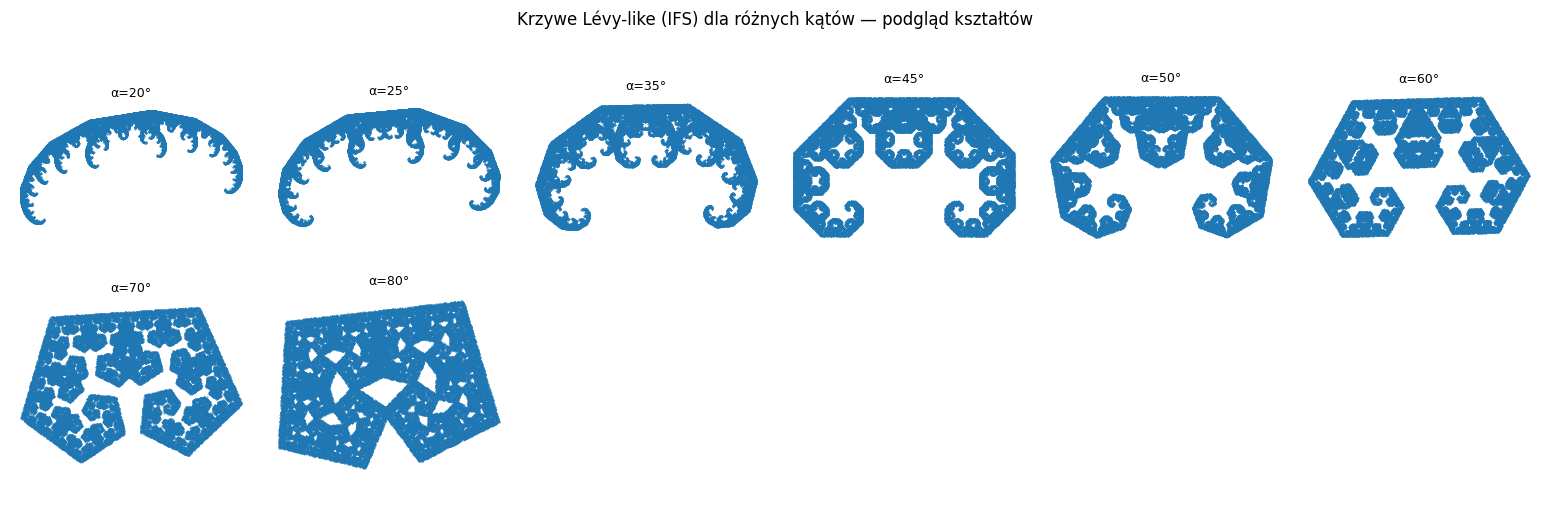

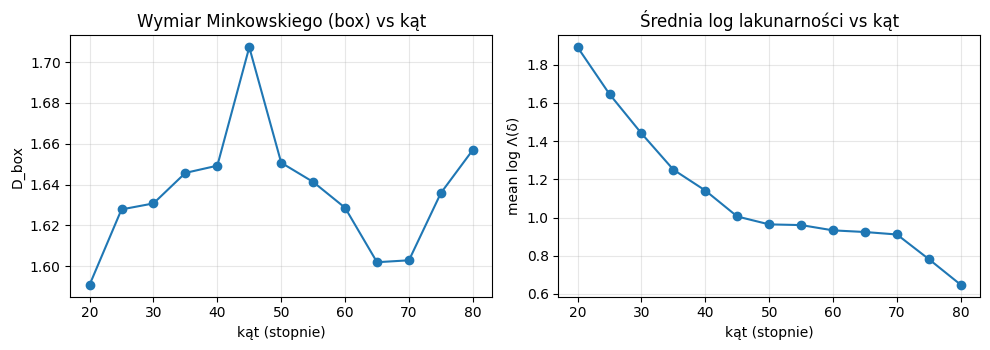

In [9]:
angles = np.linspace(20, 80, 13)
n_points = 60_000
discard = 200
seed_base = 2025

# Skale do metryk
box_deltas = [2**(-k) for k in range(3, 9)]
lac_deltas = np.logspace(-2.6, -0.7, 6)

max_per_row = 6
cell_size = 2.6

# Metryki
D_box_vals = []
lac_means = []

# Podzbior katow
subset_idx = np.linspace(0, len(angles)-1, min(len(angles), 8), dtype=int)
subset_angles = [float(angles[i]) for i in subset_idx]

cols = min(len(subset_angles), max_per_row)
rows = (len(subset_angles) + cols - 1) // cols
fig_m, axes_m = plt.subplots(rows, cols, figsize=(cell_size*cols, cell_size*rows))
axes_list = [axes_m] if (rows == 1 and cols == 1) else axes_m.ravel().tolist()

for k, a in enumerate(angles):
    ifs = levy_ifs_generalized(angle_deg=float(a))
    pts = ifs.sample(n_points=n_points, discard=discard, seed=seed_base + int(a*10))

    # Wymiar Minkowskiego (box-counting)
    fig_b, res_b = estimate_box_dimension(pts, deltas=box_deltas, title_prefix=f"α={a:.1f}°")
    plt.close(fig_b)
    D_box_vals.append(res_b.slope)

    # Lakunarnosc
    fig_l, res_l = lacunarity_gliding_box(pts, deltas=lac_deltas, title=f"α={a:.1f}°")
    plt.close(fig_l)
    lac_means.append(np.nanmean(np.log(res_l.lacunarity)))

    if k in subset_idx:
        ax = axes_list[subset_idx.tolist().index(k)]
        xs, ys = zip(*pts)
        ax.scatter(xs, ys, s=0.12)
        ax.set_title(f"α={a:.0f}°", fontsize=9)
        ax.set_aspect("equal"); ax.axis("off")

for j in range(len(subset_angles), len(axes_list)):
    axes_list[j].axis("off")

fig_m.suptitle("Krzywe Lévy-like (IFS) dla różnych kątów — podgląd kształtów")
fig_m.tight_layout()
plt.show()

# 2) Metryki vs kat
D_box_vals = np.asarray(D_box_vals, dtype=float)
lac_means  = np.asarray(lac_means,  dtype=float)

fig, ax = plt.subplots(1, 2, figsize=(10, 3.6))

# Wymiar Minkowskiego 
ax[0].plot(angles, D_box_vals, "o-")
ax[0].set_title("Wymiar Minkowskiego (box) vs kąt")
ax[0].set_xlabel("kąt (stopnie)")
ax[0].set_ylabel("D_box")
ax[0].grid(True, alpha=0.3)

# Lakunarnosc
ax[1].plot(angles, lac_means, "o-")
ax[1].set_title("Średnia log lakunarności vs kąt")
ax[1].set_xlabel("kąt (stopnie)")
ax[1].set_ylabel("mean log Λ(δ)")
ax[1].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()


## Wnioski

- Wymiar fraktalny (empirycznie): wszystkie wersje zachowują wartości zbliżone do 1.53 w sensownym zakresie skal, choć problemy numeryczne wprowadzają nieregularności względem wymiaru empirycznym, a teoretycznym.
- Zmiana kąta (IFS): zwiększa jednorodność rozkładu punktów — krzywe są „pełniejsze” lokalnie (niższa lakunarność, wyższy wymiar korelacyjny).
- Stochastyczny L-system: wprowadza drobne perturbacje reguł — struktura staje się bardziej „dziurawa” i chropowata (wyższa lakunarność, zwykle niższy wymiar korelacyjny).
- Klasyczny (L-system): zachowuje przejrzystą, regularną samopodobną budowę; służy jako dobry punkt odniesienia do porównań z modyfikacjami.
- Uwagi metodyczne: estymacja wymiaru Minkowskiego jest wrażliwa na wybór siatek i przedział skal; warto raportować kilka skal i uzupełniać analizę wymiarem korelacyjnym oraz lakunarnością.

Podsumowanie: modyfikacja kąta w IFS prowadzi do bardziej jednorodnych wizualnie fraktali, natomiast stochastyczne reguły L-systemu wzmacniają teksturę i nieregularność. Zestaw metryk (wyimar Minkowskiego, lakunarność) daje spójny obraz różnic między wariantami.
